# Artificial Neural Networks and Deep Learning    
## Assignment 3.1 - Autoencoders and Stacked Autoencoders

Prof. Dr. Ir. Johan A. K. Suykens     

In this file, we will implement two network architectures from scratch: (1) Autoencoders; (2) Stacked Autoencoders.

We will train both networks on the MNIST dataset under reconstruction learning task. All training will be conducted on a single T4 GPU.


In [ ]:
# Please first load your google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Please go to Edit > Notebook settings > Hardware accelerator > choose "T4 GPU"
# Now check if you have loaded the GPU successfully
!nvidia-smi

Fri Jul 18 13:15:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Autoencoder
In this section, we implement an Autoencoder from scratch and trainit on the MNIST dataset. With this autoencoder, we pass input data through an encoder making a compressed representation of the input, and then pass this representation to the following decoder to reconstruct the input data.
Note that in this exercise session we will be using  ``PyTorch`` instead of ``Keras`` for building and training our neural networks.


In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms

# Set the seed for reproducibility. Don't forget to comment out this line when averaging over different runs
torch.manual_seed(42)

# Convert data to torch.FloatTensor
transform = transforms.ToTensor()


train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Select only a part of the dataset to speed up training times
num_train_samples = 10000
num_test_samples = 1000

# Randomly select a subset of samples
train_indices = torch.randperm(len(train_data))[:num_train_samples]
test_indices = torch.randperm(len(test_data))[:num_test_samples]

# Create subset samplers to be used in the dataloader
train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

## Create training and test dataloaders


Dataloaders are used for efficiently loading, batching, and managing datasets in PyTorch.
During training dataloaders feed the data into the network batch by batch instead of the whole dataset at once. This allows us to handle larger datasets without running out of memory.

In [ ]:
# Choose how many samples per batch to load
# You can tune the batch size
batch_size = 32

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler = train_subset_sampler,
                                           num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          sampler = test_subset_sampler,
                                          num_workers=0)


## Visualize the data

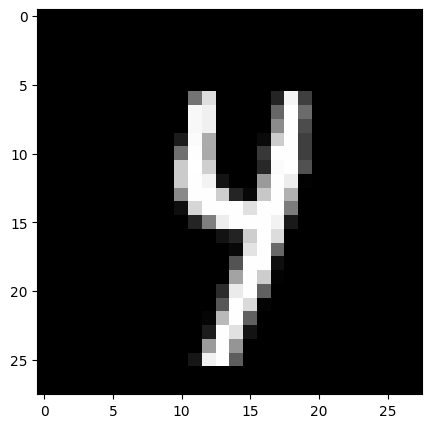

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain one batch of training images
images, labels = next(iter(train_loader)) # iter() creates an iterator over the batches in the dataloader and next() selects the next batch from this iterator.
images = images.numpy() #.numpy() turns the torch.tensor into a numpy array

# Get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Build the Linear Autoencoder
We now train a linear autoencoder on MINIST dataset.
Images of original size 28$\times$28 will be flattened into 784-dimensional vectors.
Note that images from this dataset are already normalized so that the values are between 0 and 1.
Since the images are normalized between 0 and 1, we need to use a sigmoid activation on the output layer to get values that match this input value range.

The encoder and decoder in the Autoencoder are built with one linear layer where you can tune the dimension of the hidden representation, i.e., ``encoding_dim``, to obtain models with different size.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(784, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, 784)

    def forward(self, x):
        # Define feedforward behavior and scale the *output* layer with a sigmoid activation function

        # Pass x into encoder
        out = F.relu(self.encoder(x))
        # Pass out into decoder
        out = torch.sigmoid(self.decoder(out))

        return out

In [ ]:
# Initialize the NN
# You can change the encoding_dim to obtain models with different size
encoding_dim = 32
model = Autoencoder(encoding_dim)

# Send model to GPU if available
if torch.cuda.is_available():
  model.cuda()
print(model)

Autoencoder(
  (encoder): Linear(in_features=784, out_features=32, bias=True)
  (decoder): Linear(in_features=32, out_features=784, bias=True)
)


## Training on MNIST
Training a neural network in PyTorch involves manually defining the training loop.
Here data processing, forward pass, loss computation, and optimization are explicitly specified.

Since we work on reconstruction learning tasks, we do not need the labels here but only the images.
The loss function should choose the MSE loss for reconstruction.

In [ ]:
# Specify the loss function
criterion = nn.MSELoss()

# We use Adam as the optimizer with a fixed learning rate of 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Choose the number of Epochs to train the network
n_epochs = 20
# Set model to training mode
model.train()

for epoch in range(1, n_epochs + 1):
    # Monitor training loss
    train_loss = 0.0

    # Train the model #
    # Feed the data into the network batch by batch using the dataloader
    for batch_data in train_loader:
        # _ stands in for labels
        # we do not need labels when conducting reconstruction
        images, _ = batch_data
        # Flatten images and send images to GPU
        images = images.view(images.size(0), -1)
        # Send images to GPU if possible
        if torch.cuda.is_available():
          images = images.cuda()
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # Calculate the loss between output and input images
        loss = criterion(outputs, images)
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update running training loss
        train_loss += loss.item()*images.size(0)

    # Print avg training statistics
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 2.386593
Epoch: 2 	Training Loss: 1.315528
Epoch: 3 	Training Loss: 1.040679
Epoch: 4 	Training Loss: 0.878057
Epoch: 5 	Training Loss: 0.759522
Epoch: 6 	Training Loss: 0.688439
Epoch: 7 	Training Loss: 0.636693
Epoch: 8 	Training Loss: 0.597742
Epoch: 9 	Training Loss: 0.568476
Epoch: 10 	Training Loss: 0.546332
Epoch: 11 	Training Loss: 0.530176
Epoch: 12 	Training Loss: 0.518377
Epoch: 13 	Training Loss: 0.509132
Epoch: 14 	Training Loss: 0.501971
Epoch: 15 	Training Loss: 0.495893
Epoch: 16 	Training Loss: 0.491787
Epoch: 17 	Training Loss: 0.488524
Epoch: 18 	Training Loss: 0.485783
Epoch: 19 	Training Loss: 0.483460
Epoch: 20 	Training Loss: 0.480828


## Evaluation on test set
We now evaluate the reconstruction results on the unseen test set.
We plot the original test images and their corresponding reconstruction ones.

In [ ]:
# Set model to evaluation mode
model.eval()

# Initialize metrics
test_loss = 0.0
total_correct = 0
total_samples = 0

# Disable gradient computation
with torch.no_grad():
    # Iterate over the test data
    for batch_data in test_loader:
        images, labels = batch_data

        # Flatten images
        images = images.view(images.size(0), -1)

        # Move to GPU if available
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()

        # Forward pass
        outputs = model(images)

        # Compute reconstruction loss
        loss = criterion(outputs, images)
        test_loss += loss.item() * images.size(0)

# Final metrics
avg_test_loss = test_loss / len(test_loader.dataset)

# Print results
print('Test Loss: {:.6f}'.format(avg_test_loss))

Test Loss: 0.001470


Input images in top row, reconstructions in bottom:


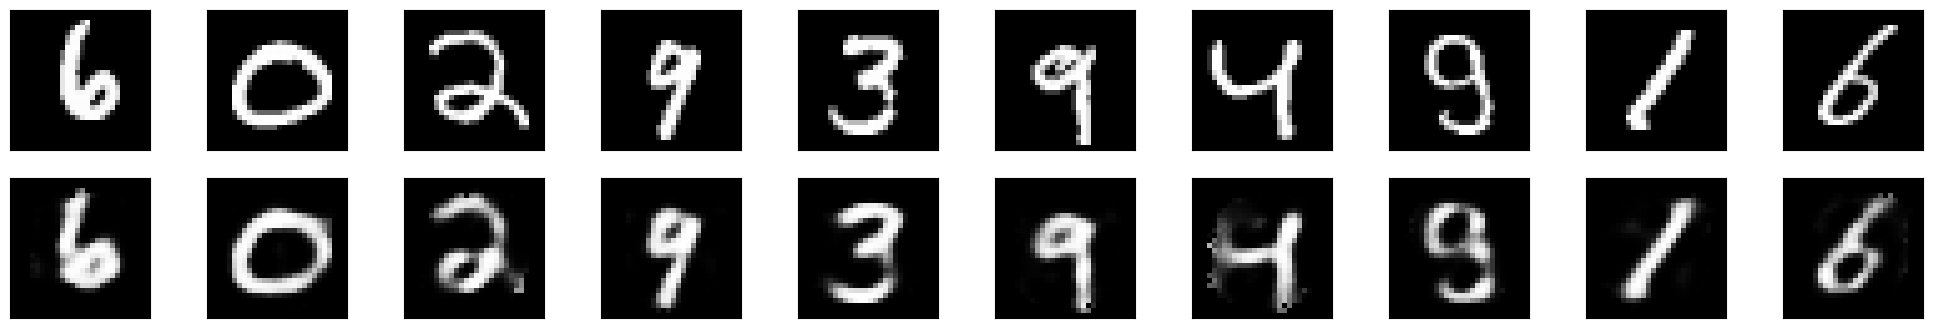

In [ ]:
# Obtain one batch of test images
test_images, test_labels = next(iter(test_loader))

test_images_flatten = test_images.view(test_images.size(0), -1)
# Set model to evaluation mode
model.eval()
# Send model back to CPU
model.cpu()
# Get sample outputs
output = model(test_images_flatten)
# Prep images for display
test_images = test_images.numpy()

# Output is resized into a batch of images
output = output.view(batch_size, 1, 28, 28)
# Use detach when it's an output that requires_grad
output = output.detach().numpy()

# Plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

print("Input images in top row, reconstructions in bottom:")
for test_images, row in zip([test_images, output], axes):
    for img, ax in zip(test_images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

Autoencoder(
  (encoder): Linear(in_features=784, out_features=16, bias=True)
  (decoder): Linear(in_features=16, out_features=784, bias=True)
)
Epoch: 1 	Training Loss: 2.790682
Test Loss: 1.930153
Input images in top row, reconstructions in bottom:


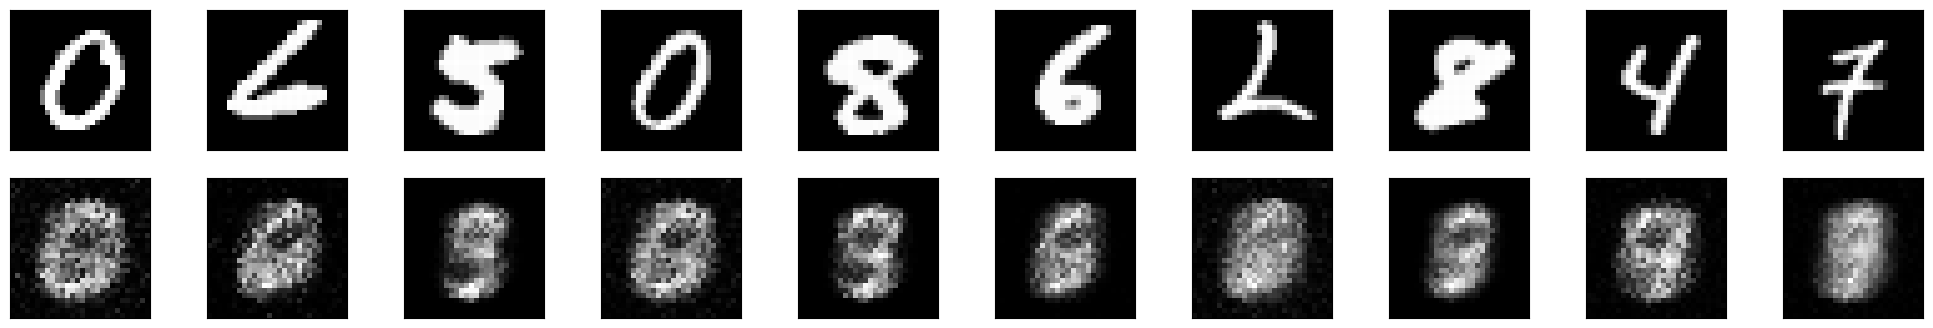

Epoch: 2 	Training Loss: 1.711563
Epoch: 3 	Training Loss: 1.427807
Epoch: 4 	Training Loss: 1.284308
Epoch: 5 	Training Loss: 1.181387
Epoch: 6 	Training Loss: 1.109798
Epoch: 7 	Training Loss: 1.059241
Epoch: 8 	Training Loss: 1.024884
Epoch: 9 	Training Loss: 0.999793
Epoch: 10 	Training Loss: 0.981981
Test Loss: 0.944008
Input images in top row, reconstructions in bottom:


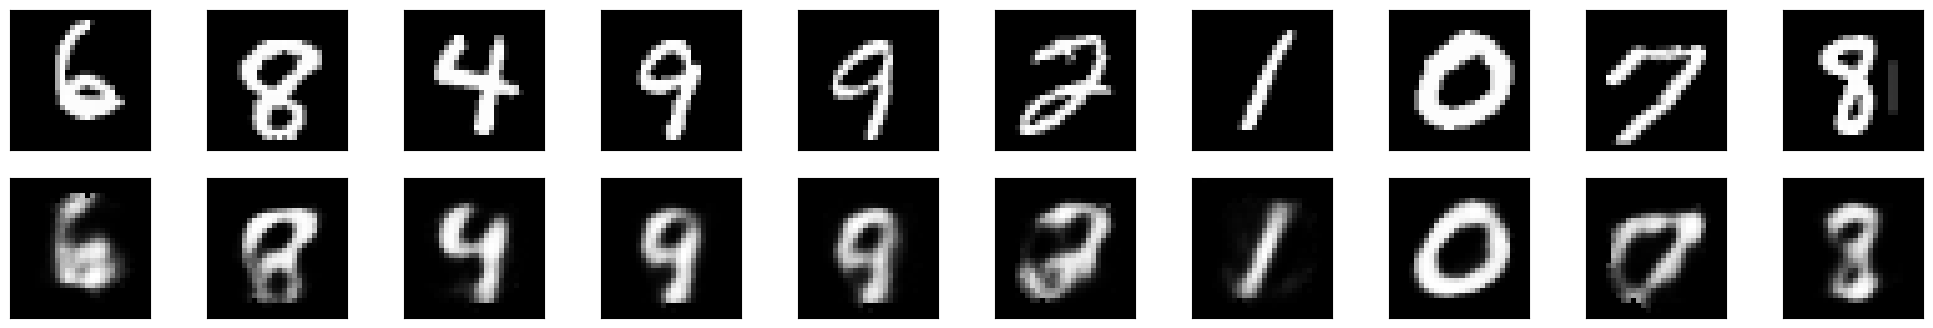

Epoch: 11 	Training Loss: 0.966567
Epoch: 12 	Training Loss: 0.955152
Epoch: 13 	Training Loss: 0.944990
Epoch: 14 	Training Loss: 0.937380
Epoch: 15 	Training Loss: 0.930335
Epoch: 16 	Training Loss: 0.924275
Epoch: 17 	Training Loss: 0.919585
Epoch: 18 	Training Loss: 0.915559
Epoch: 19 	Training Loss: 0.911599
Epoch: 20 	Training Loss: 0.908432
Test Loss: 0.876796
Input images in top row, reconstructions in bottom:


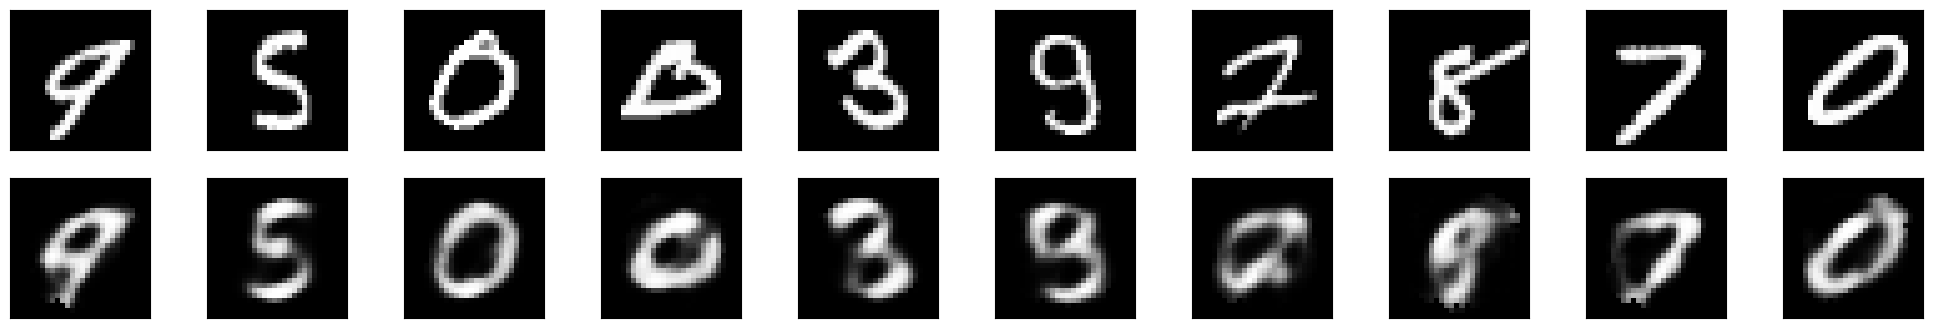

Epoch: 21 	Training Loss: 0.905955
Epoch: 22 	Training Loss: 0.903494
Epoch: 23 	Training Loss: 0.900933
Epoch: 24 	Training Loss: 0.898675
Epoch: 25 	Training Loss: 0.896623
Epoch: 26 	Training Loss: 0.895440
Epoch: 27 	Training Loss: 0.893349
Epoch: 28 	Training Loss: 0.891687
Epoch: 29 	Training Loss: 0.889664
Epoch: 30 	Training Loss: 0.888162
Epoch: 31 	Training Loss: 0.887114
Epoch: 32 	Training Loss: 0.885173
Epoch: 33 	Training Loss: 0.883285
Epoch: 34 	Training Loss: 0.881913
Epoch: 35 	Training Loss: 0.880925
Epoch: 36 	Training Loss: 0.879970
Epoch: 37 	Training Loss: 0.878877
Epoch: 38 	Training Loss: 0.877533
Epoch: 39 	Training Loss: 0.876750
Epoch: 40 	Training Loss: 0.875580
Test Loss: 0.850484
Input images in top row, reconstructions in bottom:


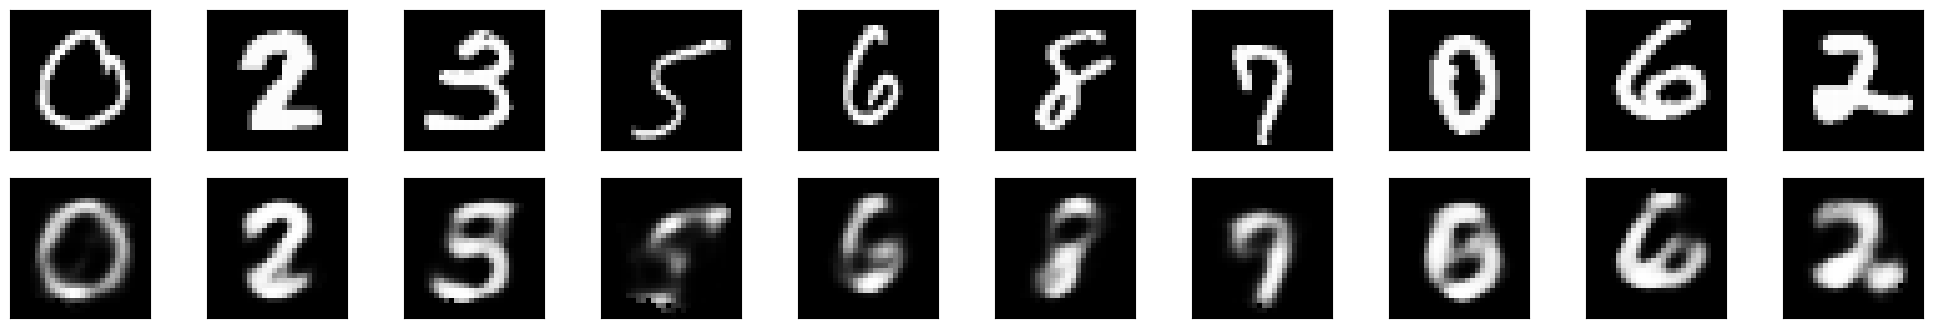

Epoch: 41 	Training Loss: 0.875193
Epoch: 42 	Training Loss: 0.874053
Epoch: 43 	Training Loss: 0.873024
Epoch: 44 	Training Loss: 0.872446
Epoch: 45 	Training Loss: 0.871385
Epoch: 46 	Training Loss: 0.869764
Epoch: 47 	Training Loss: 0.868700
Epoch: 48 	Training Loss: 0.868032
Epoch: 49 	Training Loss: 0.867276
Epoch: 50 	Training Loss: 0.866828
Epoch: 51 	Training Loss: 0.866130
Epoch: 52 	Training Loss: 0.865502
Epoch: 53 	Training Loss: 0.864867
Epoch: 54 	Training Loss: 0.864821
Epoch: 55 	Training Loss: 0.864150
Epoch: 56 	Training Loss: 0.864217
Epoch: 57 	Training Loss: 0.863139
Epoch: 58 	Training Loss: 0.862322
Epoch: 59 	Training Loss: 0.862120
Epoch: 60 	Training Loss: 0.861762
Epoch: 61 	Training Loss: 0.861408
Epoch: 62 	Training Loss: 0.860815
Epoch: 63 	Training Loss: 0.860719
Epoch: 64 	Training Loss: 0.860055
Epoch: 65 	Training Loss: 0.859884
Epoch: 66 	Training Loss: 0.859304
Epoch: 67 	Training Loss: 0.859134
Epoch: 68 	Training Loss: 0.858855
Epoch: 69 	Training 

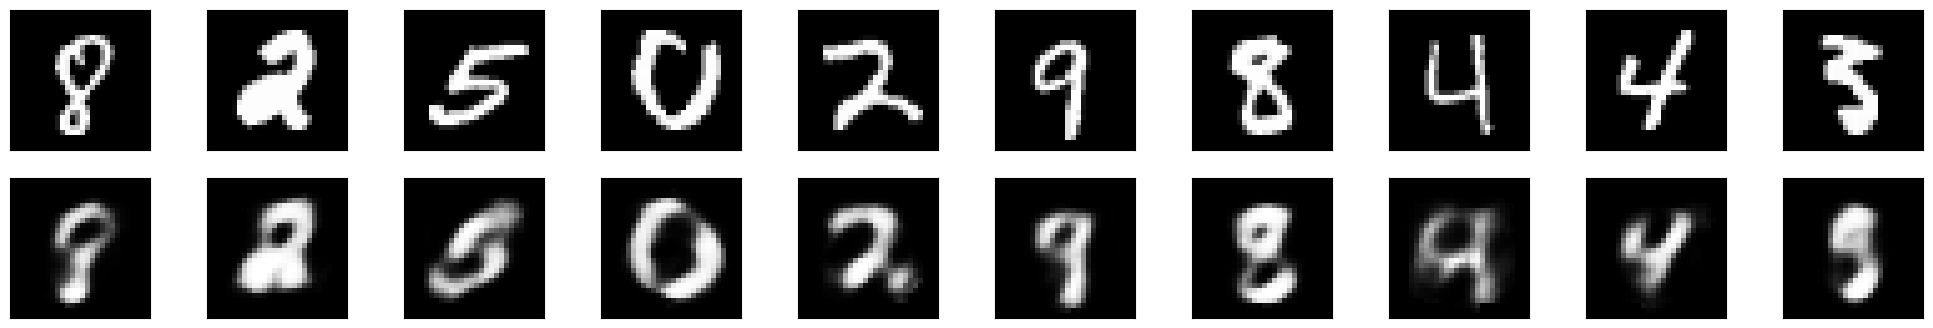

Autoencoder(
  (encoder): Linear(in_features=784, out_features=32, bias=True)
  (decoder): Linear(in_features=32, out_features=784, bias=True)
)
Epoch: 1 	Training Loss: 2.333038
Test Loss: 1.437318
Input images in top row, reconstructions in bottom:


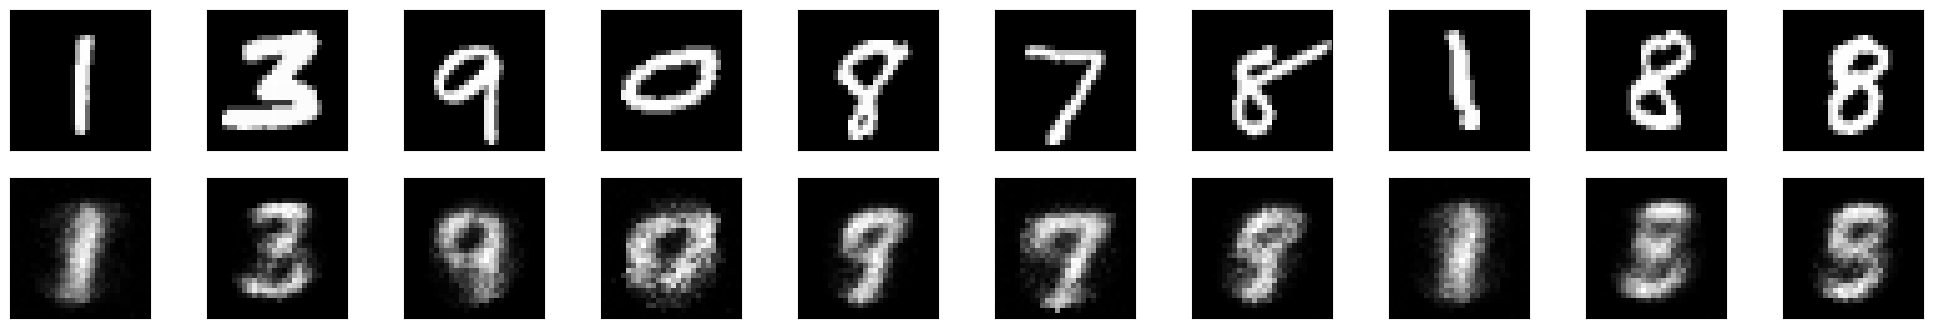

Epoch: 2 	Training Loss: 1.262955
Epoch: 3 	Training Loss: 0.989992
Epoch: 4 	Training Loss: 0.844637
Epoch: 5 	Training Loss: 0.743682
Epoch: 6 	Training Loss: 0.670365
Epoch: 7 	Training Loss: 0.615852
Epoch: 8 	Training Loss: 0.575479
Epoch: 9 	Training Loss: 0.544832
Epoch: 10 	Training Loss: 0.521552
Test Loss: 0.486962
Input images in top row, reconstructions in bottom:


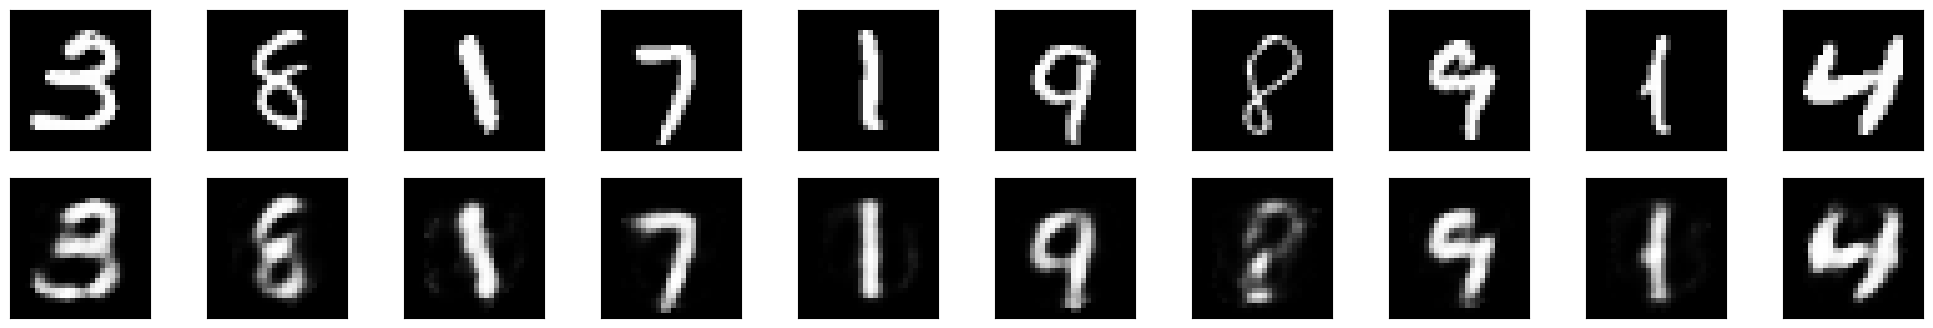

Epoch: 11 	Training Loss: 0.504212
Epoch: 12 	Training Loss: 0.490920
Epoch: 13 	Training Loss: 0.481194
Epoch: 14 	Training Loss: 0.473472
Epoch: 15 	Training Loss: 0.467475
Epoch: 16 	Training Loss: 0.462362
Epoch: 17 	Training Loss: 0.458396
Epoch: 18 	Training Loss: 0.455470
Epoch: 19 	Training Loss: 0.452433
Epoch: 20 	Training Loss: 0.449871
Test Loss: 0.427255
Input images in top row, reconstructions in bottom:


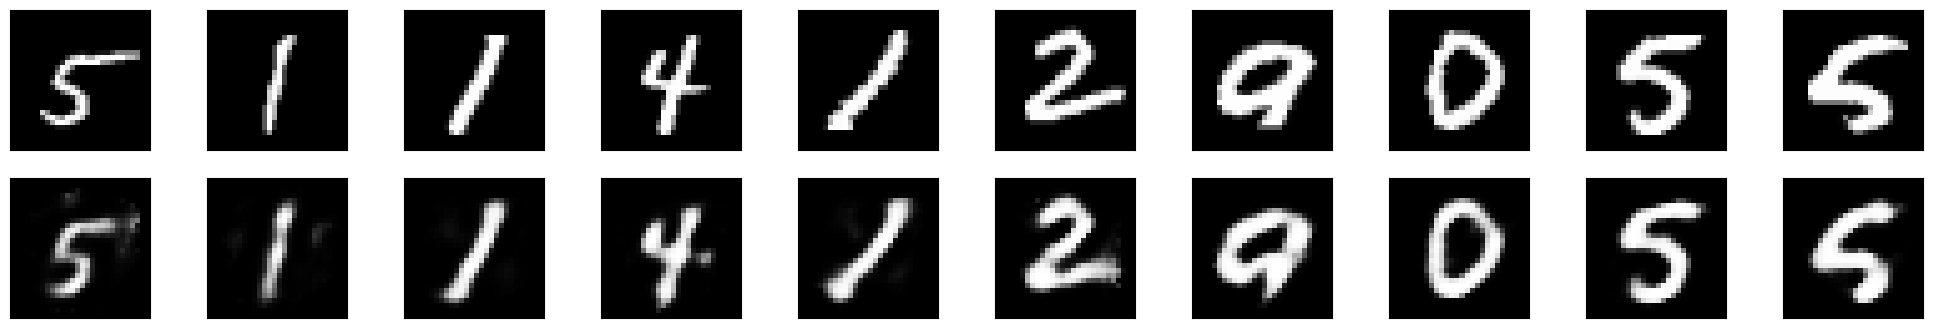

Epoch: 21 	Training Loss: 0.447907
Epoch: 22 	Training Loss: 0.446172
Epoch: 23 	Training Loss: 0.444873
Epoch: 24 	Training Loss: 0.443721
Epoch: 25 	Training Loss: 0.442275
Epoch: 26 	Training Loss: 0.441775
Epoch: 27 	Training Loss: 0.441070
Epoch: 28 	Training Loss: 0.439986
Epoch: 29 	Training Loss: 0.439116
Epoch: 30 	Training Loss: 0.438681
Epoch: 31 	Training Loss: 0.437950
Epoch: 32 	Training Loss: 0.437320
Epoch: 33 	Training Loss: 0.436638
Epoch: 34 	Training Loss: 0.436299
Epoch: 35 	Training Loss: 0.435506
Epoch: 36 	Training Loss: 0.435214
Epoch: 37 	Training Loss: 0.435147
Epoch: 38 	Training Loss: 0.434271
Epoch: 39 	Training Loss: 0.434403
Epoch: 40 	Training Loss: 0.434119
Test Loss: 0.418337
Input images in top row, reconstructions in bottom:


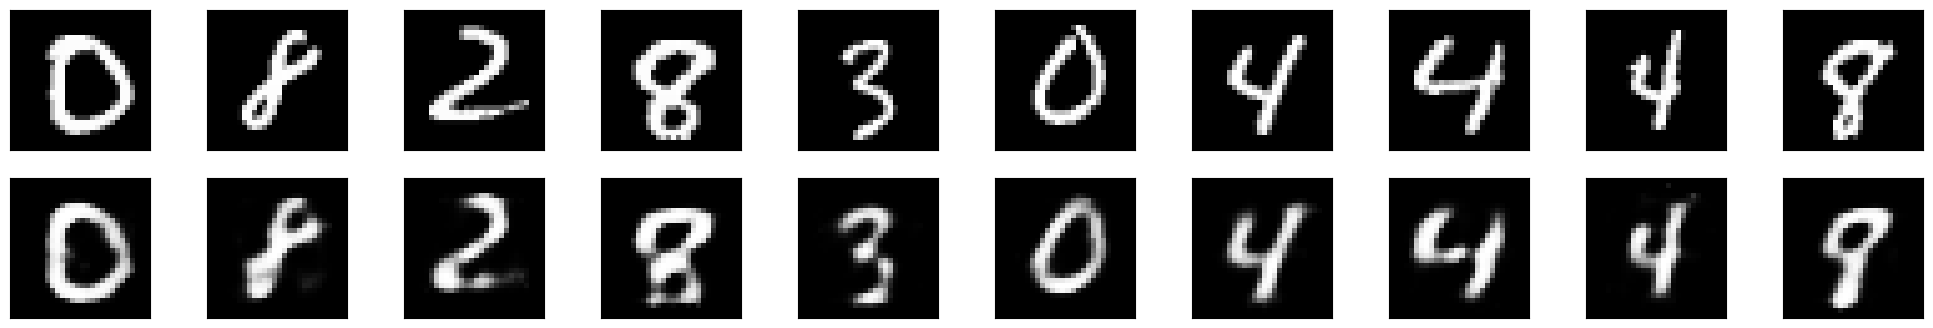

Autoencoder(
  (encoder): Linear(in_features=784, out_features=64, bias=True)
  (decoder): Linear(in_features=64, out_features=784, bias=True)
)
Epoch: 1 	Training Loss: 1.994695
Test Loss: 1.197835
Input images in top row, reconstructions in bottom:


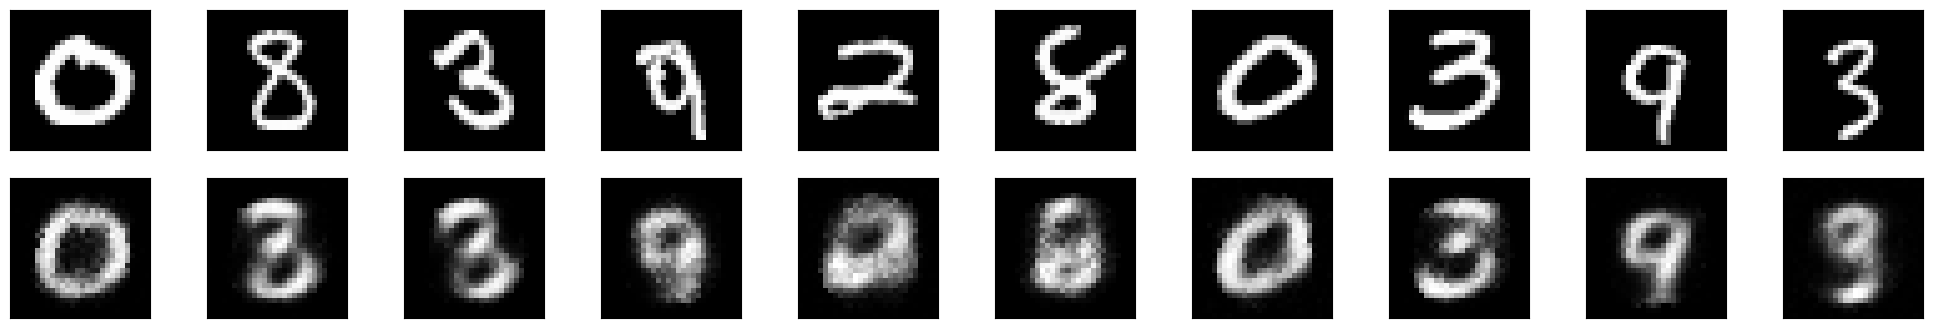

Epoch: 2 	Training Loss: 1.027872
Epoch: 3 	Training Loss: 0.754895
Epoch: 4 	Training Loss: 0.595962
Epoch: 5 	Training Loss: 0.490703
Epoch: 6 	Training Loss: 0.413947
Epoch: 7 	Training Loss: 0.354881
Epoch: 8 	Training Loss: 0.314616
Epoch: 9 	Training Loss: 0.286177
Epoch: 10 	Training Loss: 0.265893
Test Loss: 0.248487
Input images in top row, reconstructions in bottom:


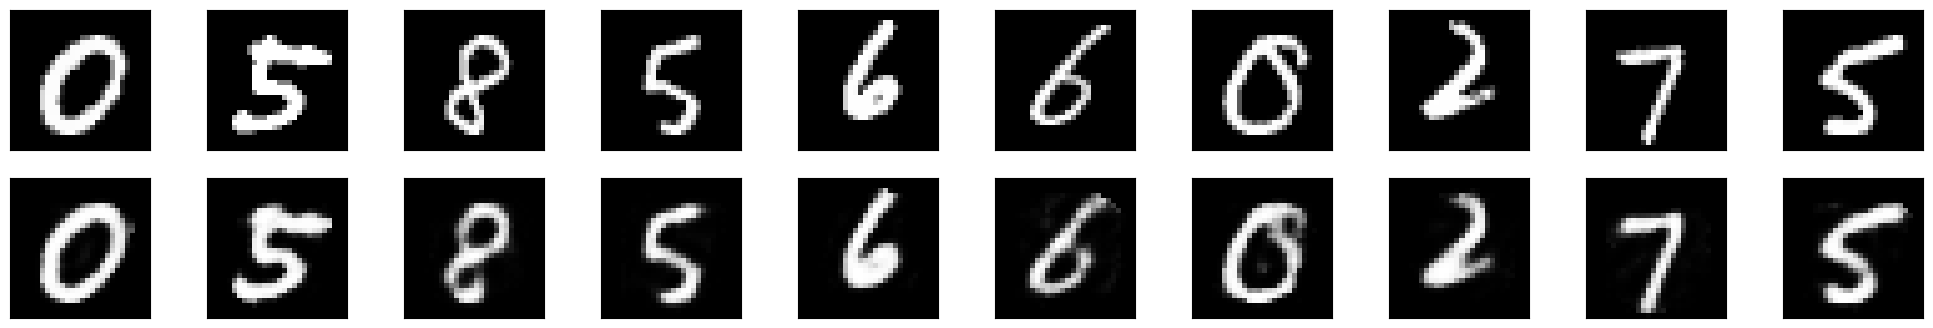

Epoch: 11 	Training Loss: 0.250712
Epoch: 12 	Training Loss: 0.239113
Epoch: 13 	Training Loss: 0.230568
Epoch: 14 	Training Loss: 0.223638
Epoch: 15 	Training Loss: 0.217826
Epoch: 16 	Training Loss: 0.213489
Epoch: 17 	Training Loss: 0.209213
Epoch: 18 	Training Loss: 0.206256
Epoch: 19 	Training Loss: 0.203718
Epoch: 20 	Training Loss: 0.201012
Test Loss: 0.196353
Input images in top row, reconstructions in bottom:


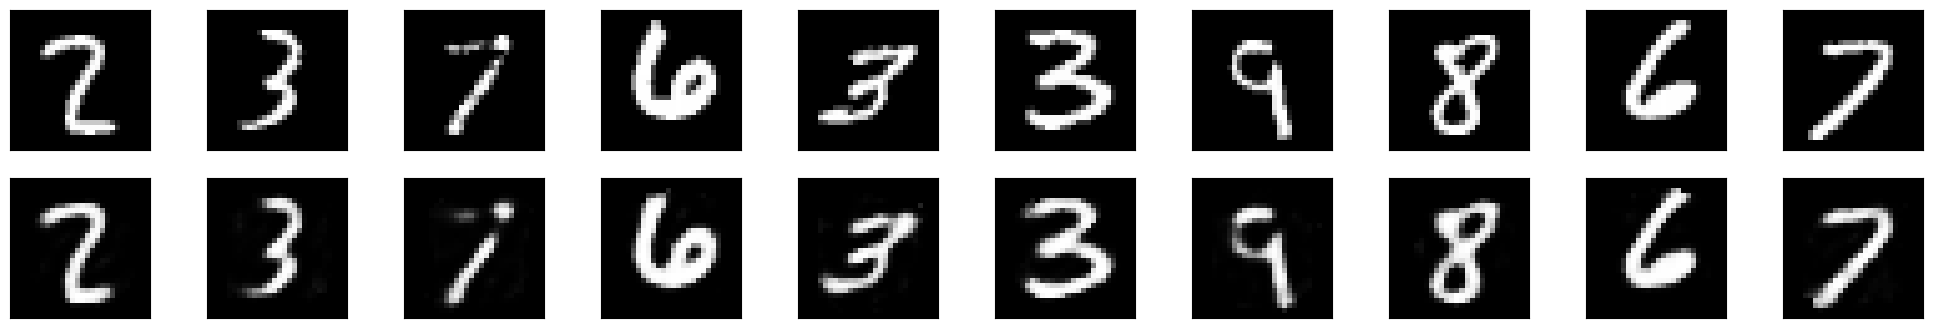

Epoch: 21 	Training Loss: 0.199214
Epoch: 22 	Training Loss: 0.197335
Epoch: 23 	Training Loss: 0.195953
Epoch: 24 	Training Loss: 0.194514
Epoch: 25 	Training Loss: 0.193368
Epoch: 26 	Training Loss: 0.192033
Epoch: 27 	Training Loss: 0.190938
Epoch: 28 	Training Loss: 0.189786
Epoch: 29 	Training Loss: 0.188826
Epoch: 30 	Training Loss: 0.188200
Epoch: 31 	Training Loss: 0.187254
Epoch: 32 	Training Loss: 0.186626
Epoch: 33 	Training Loss: 0.185803
Epoch: 34 	Training Loss: 0.185156
Epoch: 35 	Training Loss: 0.184545
Epoch: 36 	Training Loss: 0.183748
Epoch: 37 	Training Loss: 0.183477
Epoch: 38 	Training Loss: 0.182827
Epoch: 39 	Training Loss: 0.182622
Epoch: 40 	Training Loss: 0.181922
Test Loss: 0.183848
Input images in top row, reconstructions in bottom:


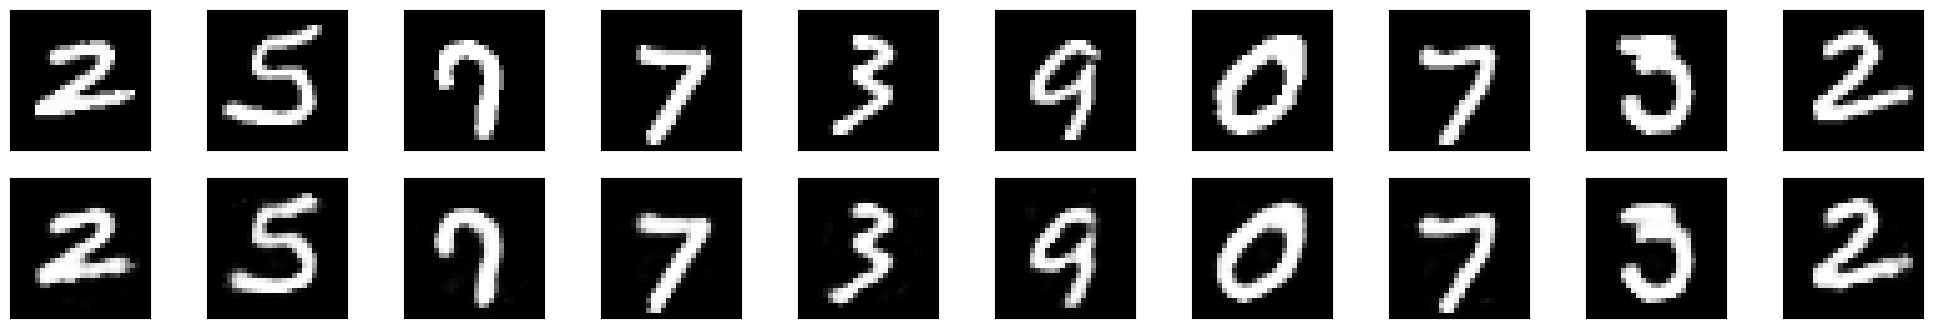

Autoencoder(
  (encoder): Linear(in_features=784, out_features=128, bias=True)
  (decoder): Linear(in_features=128, out_features=784, bias=True)
)
Epoch: 1 	Training Loss: 1.686141
Test Loss: 0.928517
Input images in top row, reconstructions in bottom:


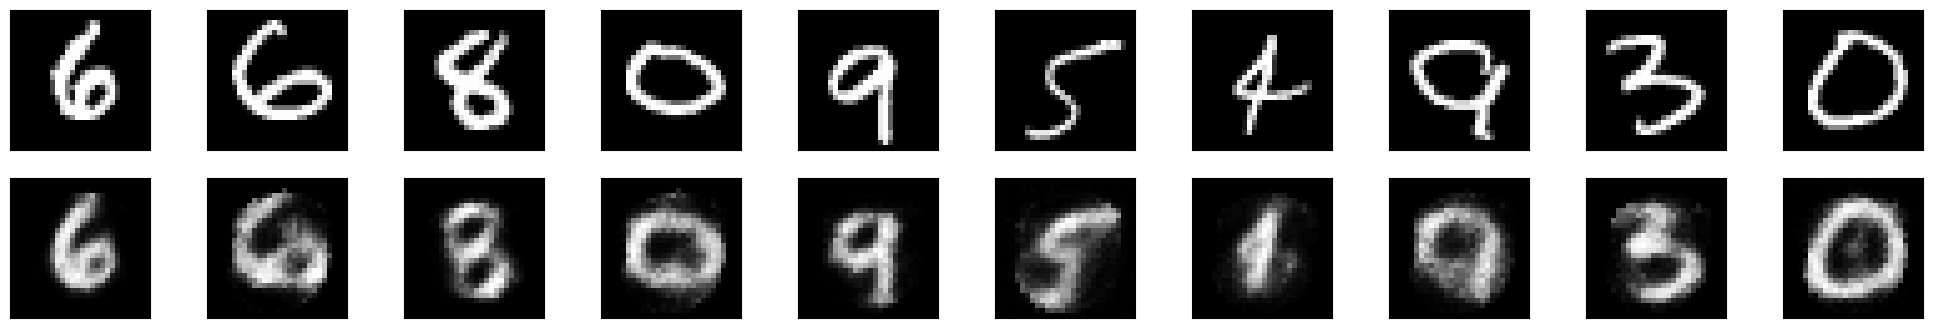

Epoch: 2 	Training Loss: 0.758445
Epoch: 3 	Training Loss: 0.499583
Epoch: 4 	Training Loss: 0.362440
Epoch: 5 	Training Loss: 0.278868
Epoch: 6 	Training Loss: 0.225747
Epoch: 7 	Training Loss: 0.189722
Epoch: 8 	Training Loss: 0.164195
Epoch: 9 	Training Loss: 0.145859
Epoch: 10 	Training Loss: 0.132388
Test Loss: 0.128141
Input images in top row, reconstructions in bottom:


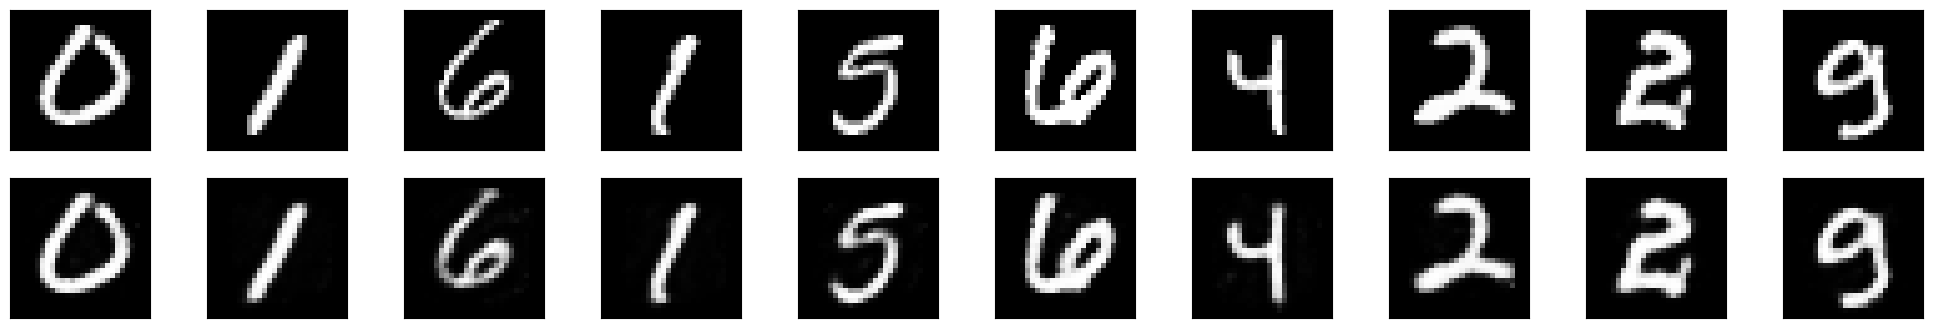

Epoch: 11 	Training Loss: 0.122283
Epoch: 12 	Training Loss: 0.114269
Epoch: 13 	Training Loss: 0.107630
Epoch: 14 	Training Loss: 0.102163
Epoch: 15 	Training Loss: 0.097555
Epoch: 16 	Training Loss: 0.093660
Epoch: 17 	Training Loss: 0.090623
Epoch: 18 	Training Loss: 0.087399
Epoch: 19 	Training Loss: 0.085194
Epoch: 20 	Training Loss: 0.082724
Test Loss: 0.087625
Input images in top row, reconstructions in bottom:


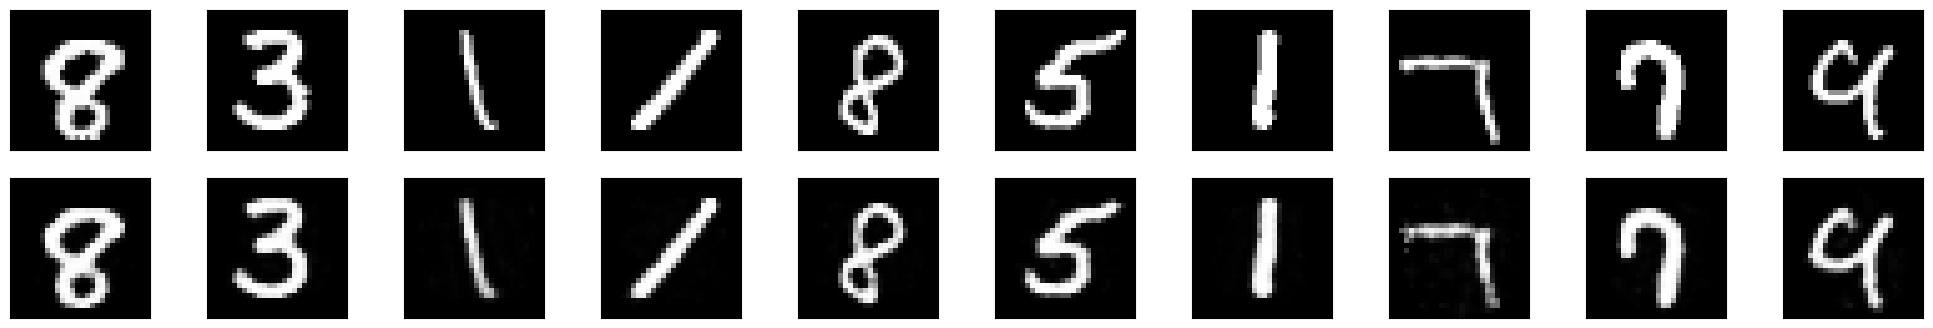

In [ ]:
# Initialize the NN
# You can change the encoding_dim to obtain models with different size
for encoding_dim, n_epochs in [(16, 80), (32, 40), (64, 40), (128, 20)]:
    model = Autoencoder(encoding_dim)

    # Send model to GPU if available
    if torch.cuda.is_available():
        model.cuda()
    print(model)

    # Specify the loss function
    criterion = nn.MSELoss()

    # We use Adam as the optimizer with a fixed learning rate of 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Set model to training mode
    model.train()

    for epoch in range(1, n_epochs + 1):
        # Monitor training loss
        train_loss = 0.0

        # Send model to GPU if available
        if torch.cuda.is_available():
            model.cuda()

        # Train the model #
        # Feed the data into the network batch by batch using the dataloader
        for batch_data in train_loader:
            # _ stands in for labels
            # we do not need labels when conducting reconstruction
            images, _ = batch_data
            # Flatten images and send images to GPU
            images = images.view(images.size(0), -1)
            # Send images to GPU if possible
            if torch.cuda.is_available():
                images = images.cuda()
            # Clear the gradients of all optimized variables
            optimizer.zero_grad()
            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # Calculate the loss between output and input images
            loss = criterion(outputs, images)
            # Backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # Perform a single optimization step (parameter update)
            optimizer.step()
            # Update running training loss
            train_loss += loss.item() * images.size(0)

        # Print avg training statistics
        train_loss = train_loss/len(train_loader)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

        if epoch in [1, 10, 20, 40, 80]:
            # Set model to evaluation mode
            model.eval()

            # Monitor test loss
            test_loss = 0.0

            # Disable gradient computation
            with torch.no_grad():
                # Iterate over the test data
                for batch_data in test_loader:
                    # Extract images from the batch
                    images, _ = batch_data
                    # Flatten images and send them to GPU
                    images = images.view(images.size(0), -1)
                    # Send to GPU
                    if torch.cuda.is_available():
                        images = images.cuda()
                    # Forward pass: compute predicted outputs by passing inputs to the model
                    outputs = model(images)
                    # Calculate the loss between output and input images
                    loss = criterion(outputs, images)
                    # Update test loss
                    test_loss += loss.item() * images.size(0)

            # Compute average test loss
            test_loss = test_loss/len(test_loader)

            # Print test loss
            print('Test Loss: {:.6f}'.format(test_loss))

            # Obtain one batch of test images
            test_images, test_labels = next(iter(test_loader))

            test_images_flatten = test_images.view(test_images.size(0), -1)
            # Send model back to CPU
            model.cpu()
            # Get sample outputs
            output = model(test_images_flatten)
            # Prep images for display
            test_images = test_images.numpy()

            # Output is resized into a batch of images
            output = output.view(batch_size, 1, 28, 28)
            # Use detach when it's an output that requires_grad
            output = output.detach().numpy()

            # Plot the first ten input images and then reconstructed images
            fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

            print("Input images in top row, reconstructions in bottom:")
            for test_images, row in zip([test_images, output], axes):
                for img, ax in zip(test_images, row):
                    ax.imshow(np.squeeze(img), cmap='gray')
                    ax.get_xaxis().set_visible(False)
                    ax.get_yaxis().set_visible(False)
            plt.show()

# Stacked Autoencoder
In this section, we implement the Stacked Autoencoder from scratch and train it on the MNIST dataset.
The training process is with two steps: (1) each layer is trained separately; (2) the network is trained as a whole.

We first load the dataset as follows:

In [ ]:
import torch
from torch import nn, optim, functional, utils

from torch.nn import BCELoss, init
from torch.utils.data.dataloader import DataLoader
import torchvision
from torchvision import datasets, utils
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import time, os

# We automate the dataloading process for future use
def get_mnist_loader(batch_size=32, num_train_samples = 6000, num_test_samples = 1000):
    """

    :return: train_loader, test_loader
    """

    transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize((0.0,), (1.0,))  # Normalize the tensor with mean 0 and standard deviation 1
    ])
    train_dataset = MNIST(root='../data',
                          train=True,
                          transform=transform,
                          download=True)
    test_dataset = MNIST(root='../data',
                         train=False,
                         transform=transform,
                         download=True)

    # Fix the random seed to select the same subset of samples
    torch.manual_seed(42)
    # Randomly select a subset of samples
    train_indices = torch.randperm(len(train_dataset))[:num_train_samples]
    test_indices = torch.randperm(len(test_dataset))[:num_test_samples]

    # Create subset samplers to be used in the dataloader
    train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_subset_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               sampler = train_subset_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              sampler = test_subset_sampler)
    return train_loader, test_loader

## Build the Stacked Autoencoder
Before building the Stacked Autoencoder, we need to build the Autoencoder layer first.

In [ ]:
class AutoEncoderLayer(nn.Module):
    """
    fully-connected linear layers for stacked autoencoders.
    This module can automatically be trained when training each layer is enabled
    Yes, this is much like the simplest auto-encoder
    """
    def __init__(self, input_dim=None, hidden_dim=None, SelfTraining=False):
        super(AutoEncoderLayer, self).__init__()
        # If input_dim is None or hidden_dim is None:
        # raise ValueError
        self.in_features = input_dim
        self.out_features = hidden_dim
        # Whether to conduct layer-by-layer pre-training, or train the entire network
        self.is_training_self = SelfTraining
        self.encoder = nn.Sequential(
            nn.Linear(self.in_features, self.out_features, bias=True),
            nn.Sigmoid()  # use Sigmoid activation function
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.out_features, self.in_features, bias=True),
            nn.Sigmoid()
        )
        #self._initialize_weights()

    def forward(self, x):
        out = self.encoder(x)
        if self.is_training_self:
            return self.decoder(out) # If the layer is not in training mode, it will just encode the data and pass it through
        else:
            return out

    def lock_grad(self):
        for param in self.parameters():
            param.requires_grad = False

    def acquire_grad(self):
        for param in self.parameters():
            param.requires_grad = True

    @property
    def input_dim(self):
        return self.in_features

    @property
    def output_dim(self):
        return self.out_features

    @property
    def is_training_layer(self):
        return self.is_training_self

    @is_training_layer.setter
    def is_training_layer(self, other: bool):
        self.is_training_self = other

## Build the stacked autoencoder

Here we stack the autoencoder layers together and add a classification layer at the end

In [ ]:
class StackedAutoEncoderClassifier(nn.Module):
    """
    Stack the trained autoencoder layers and add a classification layer at the end
    """

    def __init__(self, autoencoder_list=None, num_classes=10):
        super(StackedAutoEncoderClassifier, self).__init__()
        # Use only the encoder parts of the autoencoders
        self.encoder_layers = nn.ModuleList([autoencoder.encoder for autoencoder in autoencoder_list])
        self.num_classes = num_classes

        # Classification layer
        self.classification_layer = nn.Linear(autoencoder_list[-1].out_features, num_classes)
        #Note that we don't implement a softmax activation, as this is already taken care of in the CrossEntropyLoss class
        #(see https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

    def forward(self, x):
        encoded_representation = x
        for layer in self.encoder_layers:
            encoded_representation = layer(encoded_representation)

        # Classification layer
        output = self.classification_layer(encoded_representation)
        return output


## The training function of each layer
We need to freeze the parameters in the previous layers when training the current layer.

In [ ]:
def train_layer(layers_list=None, train_loader= None, test_loader= None, layer=None, epochs=None, validate=True):
    """
    Greedy layer-wise training: when training the i-th layer, freeze the i-1 layer
    :param layers_list: all autoencoder layers to train
    :param layer: which autoencoder layer to train
    :return:
    """
    if torch.cuda.is_available():
        for model in layers_list:
            model.cuda()

    optimizer = optim.SGD(layers_list[layer].parameters(), lr=0.1)
    criterion = torch.nn.MSELoss()

    # Train
    for epoch_index in range(epochs):
        sum_loss = 0.

        # Freeze the parameters of all layers before the current layer
        # Layer 0 has no previous layer
        if layer != 0:
            for index in range(layer):
                # In addition to freezing parameters
                # the output return method of the frozen layer must also be set.
                layers_list[index].lock_grad()
                layers_list[index].is_training_layer = False

        for batch_index, (train_data, _) in enumerate(train_loader):
            # Generate input data
            if torch.cuda.is_available():
                train_data = train_data.cuda()  # Put data onto GPU
            out = train_data.view(train_data.size(0), -1)

            # Perform forward calculation on the frozen layers before (layer-1)-th layer
            if layer != 0:
                for l in range(layer):
                    out = layers_list[l](out)

            # Train the layer-th layer
            pred = layers_list[layer](out)

            optimizer.zero_grad()
            loss = criterion(pred, out)
            sum_loss += loss
            loss.backward()
            optimizer.step()
            #if (batch_index + 1) % 20 == 0:
        print("Train Layer: {}, Epoch: {}/{}, Iter: {}/{}, Loss: {:.4f}".format(
            layer, (epoch_index + 1), epochs, (batch_index + 1), len(train_loader), loss))

        if validate:
            pass

## The training function of the whole network
Now we unfreeze all the parameters in the network that are previously frozen for the layer training.

In [ ]:
def train_classifier(model=None, train_loader=None, test_loader=None, epochs=20, fine_tuning = False):

    print(">> start training whole model")
    if torch.cuda.is_available():
        model.cuda()

    # unfreeze the parameters frozen in pre-training if needed
    if fine_tuning:
      for param in model.parameters():
          param.requires_grad = True
      training_phase = 'Fine-Tuning'
    else:
      training_phase = 'Classifier'

    optimizer = optim.SGD(model.parameters(), lr=1)
    criterion = nn.CrossEntropyLoss()

    # Set the model to training mode
    model.train()

    # train
    for epoch_index in range(epochs):
        sum_loss = 0.
        for batch_index, (train_data, train_labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                train_data, train_labels = train_data.cuda(), train_labels.cuda()
            x = train_data.view(train_data.size(0), -1)

            predicted_labels = model(x)

            optimizer.zero_grad()
            loss = criterion(predicted_labels, train_labels)
            sum_loss += loss
            loss.backward()
            optimizer.step()

        print("Train {}, Epoch: {}/{}, Iter: {}/{}, Loss: {:.4f}".format(training_phase, (epoch_index + 1), epochs, (batch_index + 1), len(train_loader), loss))

    print("<< end training whole model")
    print("Calculating accuracy on the whole test set")

    # Set model to evaluation mode
    model.eval()

    # Calculate accuracy on the test set
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for batch_data in test_loader:
            images, labels = batch_data
            images = images.view(images.size(0), -1)
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            # Get the highest value for each point to get the label
            _, predicted_labels = torch.max(outputs.data, 1)
            # Count number of correct predictions in the batch
            total_correct += (predicted_labels == labels).sum().item()
            total_samples += labels.size(0)


    # Compute average test loss
    accuracy = total_correct / total_samples
    print('Accuracy on the test set: {:.6f}'.format(accuracy))
    return model, accuracy


## Let's start training!
The default network is trained with layer epochs 10, classifier epochs 10, fine-tuning epochs 20, batch size of 128. You can try to change the hyper-parameters to obtain better reconstruction performance.

In [ ]:
# You can change the hyper-parameters here
# Be sure to try out different combinations of epochs for the pretraining and fine-tuning
num_layer_wise_epochs = 10
num_classifier_epochs = 10
num_finetuning_epochs = 20
batch_size = 128

In [ ]:
# Get the dataloaders of the training dataset
train_loader, test_loader = get_mnist_loader(batch_size=batch_size)

input_dim = 784
# Define the autoencoder layers
# Try different values for the dimensions of the hidden layers and the number of layers
encoder_1 = AutoEncoderLayer(input_dim = input_dim, hidden_dim = 256, SelfTraining=True)
encoder_2 = AutoEncoderLayer(input_dim = 256, hidden_dim = 64, SelfTraining=True)

encoders_list = [encoder_1, encoder_2]
num_layers = len(encoders_list)


# Pre-train each layer
for level in range(num_layers):
   train_layer(layers_list=encoders_list, train_loader=train_loader, test_loader=test_loader, layer=level, epochs=num_layer_wise_epochs, validate=True)

# Build the stacked autoencoder
SAE_model = StackedAutoEncoderClassifier(autoencoder_list=encoders_list, num_classes=10)
# Print the model
print(SAE_model)

# First train the classification layer
train_classifier(model=SAE_model, train_loader=train_loader, test_loader=test_loader, epochs=num_classifier_epochs, fine_tuning=False)

# Train the whole model and perform fine-tuning
train_classifier(model=SAE_model, train_loader=train_loader, test_loader=test_loader, epochs=num_finetuning_epochs, fine_tuning=True)


# Save the model (refer: https://pytorch.org/docs/master/notes/serialization.html)
import os
if not os.path.exists('./models'):
    os.makedirs('./models')
torch.save(SAE_model, './models/sae_model.pt')

Train Layer: 0, Epoch: 1/10, Iter: 47/47, Loss: 0.2178
Train Layer: 0, Epoch: 2/10, Iter: 47/47, Loss: 0.2037
Train Layer: 0, Epoch: 3/10, Iter: 47/47, Loss: 0.1910
Train Layer: 0, Epoch: 4/10, Iter: 47/47, Loss: 0.1802
Train Layer: 0, Epoch: 5/10, Iter: 47/47, Loss: 0.1697
Train Layer: 0, Epoch: 6/10, Iter: 47/47, Loss: 0.1603
Train Layer: 0, Epoch: 7/10, Iter: 47/47, Loss: 0.1516
Train Layer: 0, Epoch: 8/10, Iter: 47/47, Loss: 0.1448
Train Layer: 0, Epoch: 9/10, Iter: 47/47, Loss: 0.1382
Train Layer: 0, Epoch: 10/10, Iter: 47/47, Loss: 0.1304
Train Layer: 1, Epoch: 1/10, Iter: 47/47, Loss: 0.0074
Train Layer: 1, Epoch: 2/10, Iter: 47/47, Loss: 0.0068
Train Layer: 1, Epoch: 3/10, Iter: 47/47, Loss: 0.0064
Train Layer: 1, Epoch: 4/10, Iter: 47/47, Loss: 0.0058
Train Layer: 1, Epoch: 5/10, Iter: 47/47, Loss: 0.0054
Train Layer: 1, Epoch: 6/10, Iter: 47/47, Loss: 0.0053
Train Layer: 1, Epoch: 7/10, Iter: 47/47, Loss: 0.0051
Train Layer: 1, Epoch: 8/10, Iter: 47/47, Loss: 0.0048
Train Lay

In [ ]:
for hidden_dim_1, hidden_dim_2 in [(64, 32), (128, 32), (128, 64), (256, 64), (256, 128), (512, 128)]:
    # Get the dataloaders of the training dataset
    train_loader, test_loader = get_mnist_loader(batch_size=batch_size)

    input_dim = 784
    # Define the autoencoder layers
    # Try different values for the dimensions of the hidden layers and the number of layers
    encoder_1 = AutoEncoderLayer(input_dim = input_dim, hidden_dim = hidden_dim_1, SelfTraining=True)
    encoder_2 = AutoEncoderLayer(input_dim = hidden_dim_1, hidden_dim = hidden_dim_2, SelfTraining=True)

    encoders_list = [encoder_1, encoder_2]
    num_layers = len(encoders_list)


    # Pre-train each layer
    print("Pre-training:")
    for level in range(num_layers):
      train_layer(layers_list=encoders_list, train_loader=train_loader, test_loader=test_loader, layer=level, epochs=num_layer_wise_epochs, validate=True)

    # Build the stacked autoencoder
    SAE_model = StackedAutoEncoderClassifier(autoencoder_list=encoders_list, num_classes = 10)
    # Print the model
    print(SAE_model)

    # First train the classification layer
    print("Training the classifier:")
    train_classifier(model=SAE_model, train_loader=train_loader, test_loader=test_loader, epochs=num_classifier_epochs, fine_tuning = False)

    # Train the whole model and perform fine-tuning
    print("Fine-tuning the classifier:")
    train_classifier(model=SAE_model, train_loader=train_loader, test_loader=test_loader, epochs=num_finetuning_epochs, fine_tuning = True)


    # Save the model (refer: https://pytorch.org/docs/master/notes/serialization.html)
    import os
    if not os.path.exists('./models'):
      os.makedirs('./models')
    torch.save(SAE_model, './models/sae_model.pt')
    print()
    print()

Pre-training:
Train Layer: 0, Epoch: 1/10, Iter: 47/47, Loss: 0.2351
Train Layer: 0, Epoch: 2/10, Iter: 47/47, Loss: 0.2302
Train Layer: 0, Epoch: 3/10, Iter: 47/47, Loss: 0.2268
Train Layer: 0, Epoch: 4/10, Iter: 47/47, Loss: 0.2226
Train Layer: 0, Epoch: 5/10, Iter: 47/47, Loss: 0.2194
Train Layer: 0, Epoch: 6/10, Iter: 47/47, Loss: 0.2155
Train Layer: 0, Epoch: 7/10, Iter: 47/47, Loss: 0.2113
Train Layer: 0, Epoch: 8/10, Iter: 47/47, Loss: 0.2069
Train Layer: 0, Epoch: 9/10, Iter: 47/47, Loss: 0.2035
Train Layer: 0, Epoch: 10/10, Iter: 47/47, Loss: 0.1995
Train Layer: 1, Epoch: 1/10, Iter: 47/47, Loss: 0.0086
Train Layer: 1, Epoch: 2/10, Iter: 47/47, Loss: 0.0075
Train Layer: 1, Epoch: 3/10, Iter: 47/47, Loss: 0.0064
Train Layer: 1, Epoch: 4/10, Iter: 47/47, Loss: 0.0058
Train Layer: 1, Epoch: 5/10, Iter: 47/47, Loss: 0.0049
Train Layer: 1, Epoch: 6/10, Iter: 47/47, Loss: 0.0046
Train Layer: 1, Epoch: 7/10, Iter: 47/47, Loss: 0.0039
Train Layer: 1, Epoch: 8/10, Iter: 47/47, Loss: 0.